<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Remove-lower-duplicates" data-toc-modified-id="Remove-lower-duplicates-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Remove lower duplicates</a></span></li><li><span><a href="#Remove-dupes-from-anomaly-labels-to-predict" data-toc-modified-id="Remove-dupes-from-anomaly-labels-to-predict-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Remove dupes from anomaly labels to predict</a></span></li><li><span><a href="#TS-vs-EMA" data-toc-modified-id="TS-vs-EMA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>TS vs EMA</a></span></li></ul></div>

In [1]:
data = pd.read_csv('data_test.csv', sep="\t")
anomaly = pd.read_csv('anomaly.csv', sep="\t")
anomaly['anomaly'] = 1

In [2]:
time_dupe = anomaly.groupby('timestamp_minutes5').filter(lambda x: len(x)>1).drop_duplicates()['timestamp_minutes5']
time_dupe = pd.to_datetime(time_dupe, unit='s')

In [3]:
anomaly = anomaly.drop_duplicates()
out = pd.merge(data, anomaly, how="left").fillna(0)
out['timestamp_minutes5'] = pd.to_datetime(out['timestamp_minutes5'], unit='s')
out['dupe'] = out.groupby('timestamp_minutes5')['anomaly'].transform(lambda x: len(x)>1)
out.set_index('timestamp_minutes5', inplace=True)

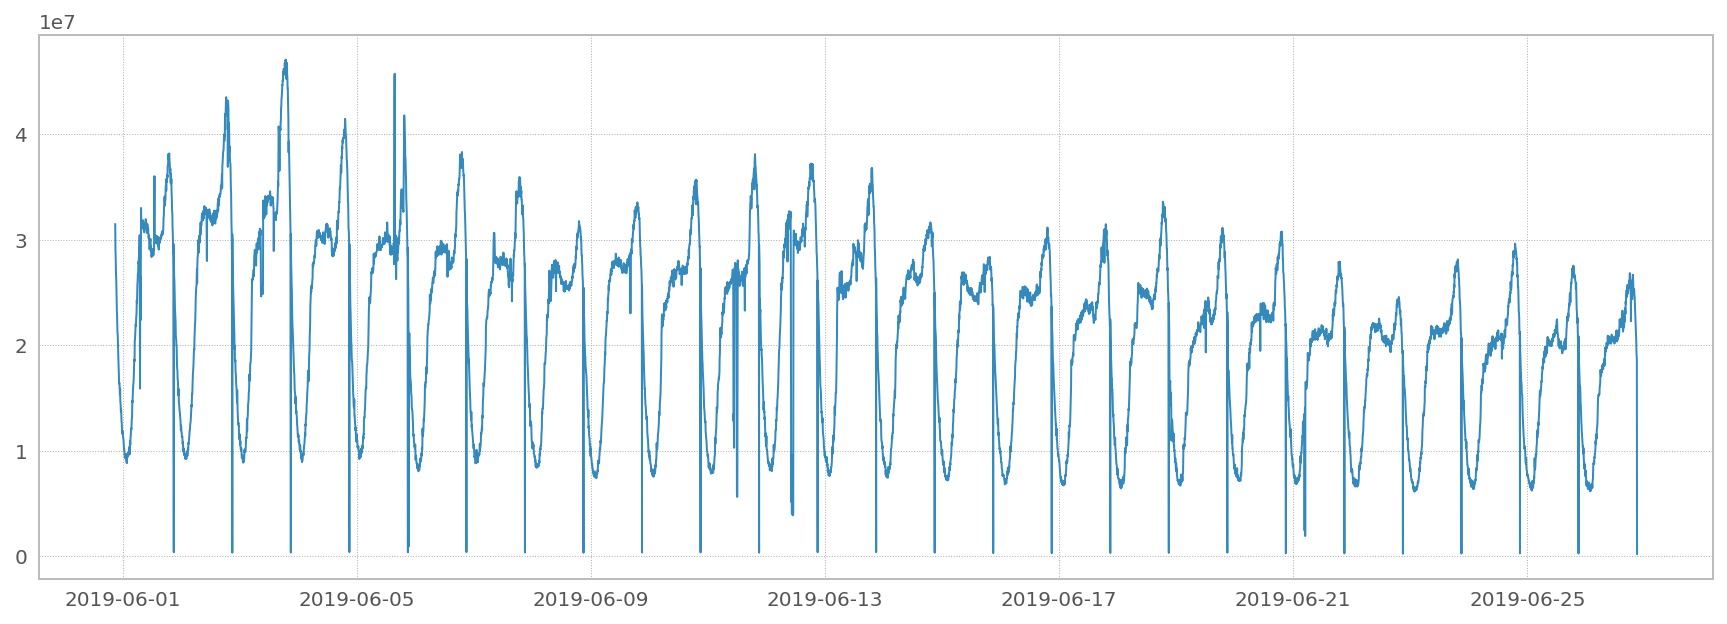

In [4]:
plt.plot(out['sum_count'])

# Remove lower duplicates

In [5]:
len(out)

7514

In [6]:
out[out.index=="2019-06-01 21:00:00"]

,sum_count,anomaly,dupe
timestamp_minutes5,,,
2019-06-01 21:00:00,374142.0,1.0,True
2019-06-01 21:00:00,29557885.0,1.0,True


In [7]:
out = out.reset_index().sort_values(["timestamp_minutes5", "sum_count"]).drop_duplicates(['timestamp_minutes5'],keep='last').set_index('timestamp_minutes5')

In [8]:
len(out)

7489

In [9]:
out[out.index=="2019-06-01 21:00:00"]

,sum_count,anomaly,dupe
timestamp_minutes5,,,
2019-06-01 21:00:00,29557885.0,1.0,True


In [10]:
out.reset_index()['timestamp_minutes5'].diff().value_counts()

0 days 00:05:00    7488
Name: timestamp_minutes5, dtype: int64

# Remove dupes from anomaly labels to predict

In [11]:
out['anomaly'].sum()

98.0

In [12]:
len(time_dupe)

25

In [13]:
out.loc[time_dupe,'anomaly'] = 0.0

In [14]:
out['anomaly'].sum()

73.0

# TS vs EMA

In [15]:
ts = out.copy()
ts["ewma"] = (
    out["sum_count"]
    .ewm(span=20, min_periods=0, adjust=False, ignore_na=False)
    .mean()
    .values
)

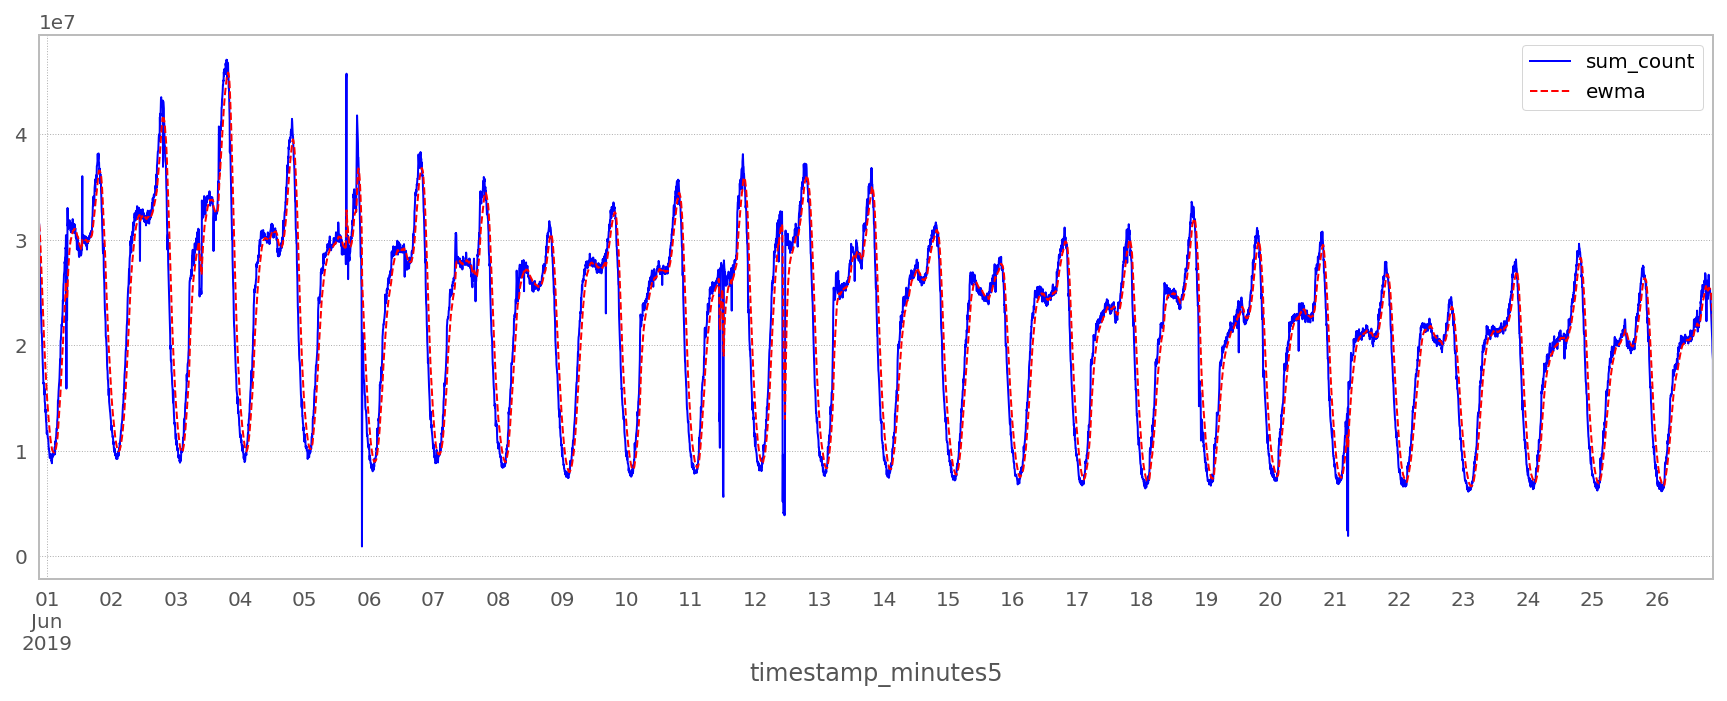

In [16]:
ts[['sum_count','ewma']].plot(style={'sum_count':'b-','ewma':'r--'});

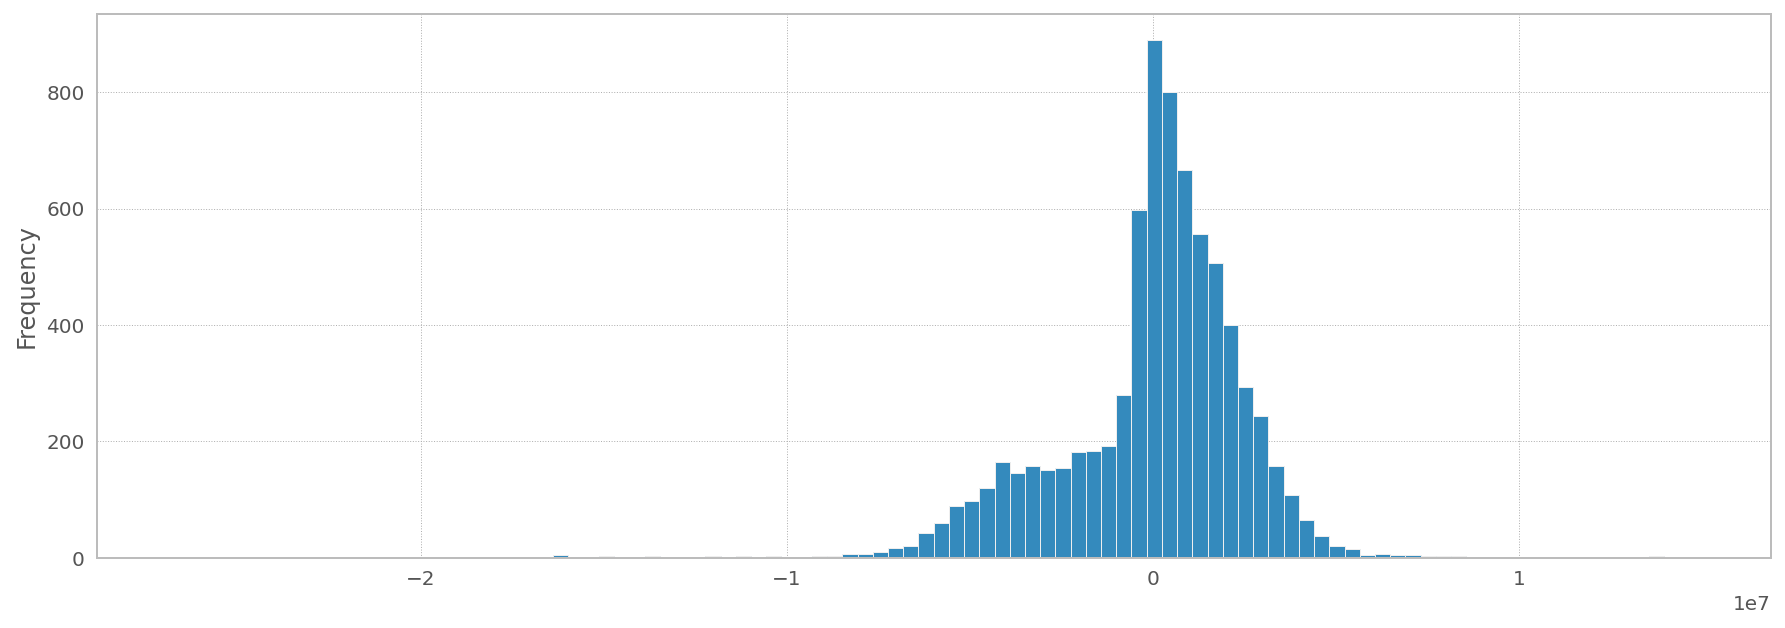

In [21]:
ts['diff'] = ts['sum_count'] - ts['ewma']
std = ts['diff'].std()
ts['diff'].plot(kind='hist', bins=100);

In [30]:
mx = 0
mult = 0
for i in [1,2,3]:
    curr = (ts["anomaly"] == (ts["diff"].abs() > i * std)).mean()
    if curr > mx:
        mx = curr
        mult = i
mx, mult

(0.9913206035518761, 3)